# Computational Methods in Simulation (CMIS) Week 7
This notebook is intended to help students make their hand-in in the last two weeks of CMIS.

Hand-ins must be submitted as a maximum 10 page pdf file in Absalon and must be made using the ACM TOG overleaf latex template

https://www.overleaf.com/latex/templates/association-for-computing-machinery-acm-large-2-column-format-template/qwcgpbmkkvpq

Notebooks must be uploaded as well so teachers have code solutions accessible if needed.

This week is based on Slides 21 - follow the detailed instructions in order to build your own simulator:

* Hints: You might want to re-visit your FEM and FVM code pieces and reuse subparts of them for this larger project. The meshing week might prove useful for creating your own test cases to play with.

* Derive theory of how to create your own FVM simulator for simulating dynamic hyperelastic materials using a Saint-Vernant-Kirchoff model and a semi-implicit time-stepping scheme.
* Design experiments for verification and validation of your own simulator
* Present results of your experiments and discuss your findings
* If time is available try and extend the simulator to use adaptive or higher order time-stepping
* If time is available try and extend the simulator to use other types of material models
* If time is available try and extend the simulator to have dynamic boundary conditions to model "contact" when objects move around.

## Important Remark

* Do not be too agressive in terms of too large time-step size, too stiff materials and too large gravity. The semi-explicit nature of this overall method is quite sensitive, so use soft materials, almost no gravity and very small time-steps is recommended for prototyping and initial implementation. Once, it has been verified that code works, one can crank up values as close to reality as possible.

## Detailed Expected Learning Objectives in The Hand-in of this Week

* Combine and show all skills learned through out the course.
* Design interesting and relevant experiments for verification and validation.
* Successfully create and discuss experimental results.
* Demonstrate ability to scientific discuss and reflect on the simulator.

In [1]:
#%matplotlib widget

In [2]:
import igl
import meshplot as mp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

# Handling Mesh Geometry Information
In this week we may be able to resue material from previous weeks. In particular the beam mesh genreation function will be useful to us.

However, we make one important slight change to this mesh generation function to avoid ear-triangles when we ask it to generate an even number of horitonal and vertical nodes.

Ear triangles form a degenerate control volume and we do not like them for this reason. The most easy fix is to make sure we never generate ear-triangle in the first place.

In [3]:
def vec2(x,y):
    return np.array([x, y],dtype=np.float64)


def hat(p):
    return vec2(-p[1], p[0])


def compute_triangle_areas(V,T):
    E = len(T) # Total number of triangles in the mesh
    A = np.zeros((E,),dtype=np.float64)
    for e in range(E):
        # Get triangle indices
        i = T[e,0]
        j = T[e,1]
        k = T[e,2]
        # Get triangle coordinates
        xi = V[i,0]
        xj = V[j,0]
        xk = V[k,0]
        yi = V[i,1]
        yj = V[j,1]
        yk = V[k,1]    
        
        dx1 = xk - xj
        dy1 = yk - yj
        dx2 = xi - xj
        dy2 = yi - yj

        A[e] =  (dx1*dy2 - dx2*dy1 ) / 2.0
    return A


def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I+1)*(J+1),2),dtype=np.float64)
    for j in range(J+1):
        for i in range(I+1):
            k = i + j*(I+1)
            V[k,0] = x0 + i*dx
            V[k,1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32)
    for j in range(J):
        for i in range(I):
            k00 = (i  ) + (j  )*(I+1)
            k01 = (i+1) + (j  )*(I+1)
            k10 = (i  ) + (j+1)*(I+1)
            k11 = (i+1) + (j+1)*(I+1)
            e = 2*(i + j*I)
            if (i+j+1)%2:
                T[e,  :] = (k00,k01,k11)
                T[e+1,:] = (k00,k11,k10)
            else:
                T[e,  :] = (k10,k00,k01)
                T[e+1,:] = (k10,k01,k11)                    
    return V, T

Later we will need to build a data structure for our control volumes. To create the control volumes we need to be able to query the mesh about connectivity information and geometric information as well. That is things like all triangles that share the same vertex or the outward unit normals of a triangle and so on.

To make this easy we provide a MeshInfo class that encapsulates simple libigl functionality into a more human readiable interface.

It is a great help to know how to "jump" around neighbors in a mesh data structure. We encourage therefore that students spend a bit of time getting into how this works so they can extend and customize their data structures as they need to with little effort.

In [4]:
class MeshInfo:
    
    def __init__(self, V, T):        
        self.A = compute_triangle_areas(V,T)
        if np.any(np.where(self.A<=0)):
            raise ValueError('Triangle with negative orientation exist.')
        bc = igl.barycenter(V,T)
        E = igl.edges(T)
        TT, _ = igl.triangle_triangle_adjacency(T)
        VT, NI = igl.vertex_triangle_adjacency(T, len(V))
        VV = igl.adjacency_list(T)
        self.V = V    # Vertices
        self.T = T    # Triangles
        self.E = E    # Edges
        self.TT = TT  # Triangle neighbors of triangles
        self.VT = VT  # Triangle neighbors of vertices
        self.NI = NI  # Vertex neighbor indices used to extract triangle neighbors of vertices
        self.VV = VV  # Vertex neighbors of vertices
        self.bc = bc  # Barycenters of triangles        
        mask = np.zeros(len(V),dtype=np.int)
        mask[igl.boundary_loop(T)] = 1
        self.boundary_vertex = mask # Boundary mask of vertices, if 1 then a vertex is boundary otherwise it is interior.
        
    def get_triangles_of_vertex(self, i):
        start = self.NI[i]
        end = self.NI[i+1]
        return self.VT[ start:end]

    def get_triangles_of_triangle(self, t):
        return self.TT[t]
    
    def get_triangle_center(self,t):
        return self.bc[t]
    
    def get_vertices_of_vertex(self, i):
        return self.VV[i]
    
    def get_triangle_area(self,t):
        return self.A[t]
    
    def get_edge_vector_of_triangle(self, t, e):
        i = self.T[t,e]
        j = self.T[t,(e+1)%3]
        vi = self.V[i,:].flatten()
        vj = self.V[j,:].flatten()
        u = (vj-vi).flatten()
        return u, (vi+vj)/2

    def get_outward_normal_of_triangle(self, t, e):
        u, m = self.get_edge_vector_of_triangle(t,e)
        n = -hat(u)/np.linalg.norm(u)
        return n, m
    
    def get_triangle_triangle_segment(self, t, e):
        n = self.TT[t,e]
        if n>0:
            ct = self.bc[t].flatten()
            cn = self.bc[n].flatten()
            return cn-ct, (cn+ct)/2
        return None, None    

    def get_opposing_triangle(self, t, v):
        e = (v+1)%3
        return self.TT[t,e]
    
    def is_boundary_vertex(self,v):
        if self.boundary_vertex[v]==1:
            return True
        return False

We will now run a simplel test example of the mesh generation and mesh info data structure to verify that things are working as expected. 

In particular we want to make sure we have no ears in the mesh, and all neighborhood information are in order too.

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


vertex  0  has triangle neighbors  [0 1]
vertex  1  has triangle neighbors  [0 2]
vertex  2  has triangle neighbors  [2 3]
vertex  3  has triangle neighbors  [1 4]
vertex  4  has triangle neighbors  [0 1 2 3 4 5 6 7]
vertex  5  has triangle neighbors  [3 6]
vertex  6  has triangle neighbors  [4 5]
vertex  7  has triangle neighbors  [5 7]
vertex  8  has triangle neighbors  [6 7]
Triangle  0  has triangle neighbors  [-1  2  1]
Triangle  1  has triangle neighbors  [ 0  4 -1]
Triangle  2  has triangle neighbors  [ 0 -1  3]
Triangle  3  has triangle neighbors  [ 2 -1  6]
Triangle  4  has triangle neighbors  [-1  1  5]
Triangle  5  has triangle neighbors  [ 4  7 -1]
Triangle  6  has triangle neighbors  [ 3 -1  7]
Triangle  7  has triangle neighbors  [ 6 -1  5]
vertex  0  has vertex neighbors  [1, 3, 4]
vertex  1  has vertex neighbors  [0, 2, 4]
vertex  2  has vertex neighbors  [1, 4, 5]
vertex  3  has vertex neighbors  [0, 4, 6]
vertex  4  has vertex neighbors  [0, 1, 2, 3, 5, 6, 7, 8]
verte

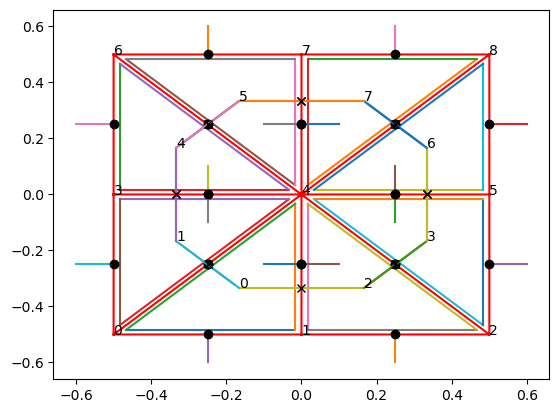

In [5]:
V, T = make_beam_mesh(1.0,1.0,(2,2))

info = MeshInfo(V,T)

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='r')
for v in range(len(V)):
    print('vertex ',v , ' has triangle neighbors ',info.get_triangles_of_vertex(v))
    plt.text(info.V[v,0],info.V[v,1], str(v))
for t in range(len(T)):
    print('Triangle ',t , ' has triangle neighbors ',info.get_triangles_of_triangle(t))
    c = info.get_triangle_center(t)
    plt.text(c[0],c[1], str(t))
for v in range(len(V)):
    print('vertex ',v , ' has vertex neighbors ',info.get_vertices_of_vertex(v))
for t in range(len(T)):
    c = info.get_triangle_center(t)
    for e in range(3):
        u, m = info.get_edge_vector_of_triangle(t,e)
        v = m - 0.5*u
        w = m + 0.5*u
        m = (m-c)*0.9 + c
        v = (v-c)*0.9 + c
        w = (w-c)*0.9 + c
        plt.plot([v[0], w[0]], [v[1], w[1]] )
for t in range(len(T)):
    for e in range(3):
        n, m = info.get_outward_normal_of_triangle(t,e)
        plt.plot([m[0], 0.1*n[0]+m[0]], [m[1], 0.1*n[1]+m[1]] )
        plt.plot(m[0], m[1],'ko')
for t in range(len(T)):
    for e in range(3):
        u, m = info.get_triangle_triangle_segment(t,e)
        if not u is None: 
            v = m - 0.5*u
            w = m + 0.5*u
            plt.plot([v[0], w[0]], [v[1], w[1]] )
            plt.plot(m[0], m[1],'kx')
plt.show()    

# Creating Vertex-centered Control Volumes
We may now use the mesh information functionality to quickly generate a simple control volume data structure.

We will take a rather brute-force approach and simply create a chunk of vertex-related information that is very specific to the simulation method we will immplement here.

We will exploit one very smart trick here which is to make a cyclic permulation a local copy of neighboring triangles such that the first index of each triangle is the vertex that they all have in common.

This is cleaver later on at run-time as we have explicit knowledge of where the two other vertices of each triangle is located in the vertex neighborhood. Further, it enable us to deduce a CCW order of triangles around a vertex. Although in this example we have little use of this knowledge.

In [6]:
def get_cyclic_permuation(v, triangle):
    i = triangle[0]
    j = triangle[1]
    k = triangle[2]
    if i==v:
        return [i, j, k]
    if j==v:
        return [j, k, i]
    if k==v:
        return [k, i, j]
    return [-1, -1, -1]


def get_ccw_triangle_order(v, T):
    for t in range(len(T)):
        T[t,:] = get_cyclic_permuation(v, T[t,:])    
    if len(T) == 1:
        ccw_order = np.array([0], dtype=np.int).flatten()
    else:
        ccw_order = []
        next_order = -np.ones( (len(T), ), dtype=np.int )
        prev_order = -np.ones( (len(T), ), dtype=np.int )
        for s in range(len(T)):
            A = T[s,:]
            for t in range(len(T)):
                B = T[t,:]
                if A[2]==B[1]:
                    next_order[s] = t
                if A[1]==B[2]:
                    prev_order[s] = t
        if np.any(prev_order<0):
            i = np.where(prev_order<0)[0]
            while i>=0:
                ccw_order.append(i)
                i = next_order[i]
        else:
            i = 0
            ccw_order.append(i)
            i = next_order[i]
            while i>0:
                ccw_order.append(i)
                i = next_order[i]            
        ccw_order = np.array(ccw_order, dtype=np.int).flatten()
    return ccw_order
    
    
class VertexControlVolume:

    def __init__(self, v, info):
        self.v = v
        self.c = info.V[v,:].flatten()
        self.labels = info.get_triangles_of_vertex(v)
        K = len(self.labels)        
        self.K = K
        self.boundary = info.is_boundary_vertex(v)
        
        T = info.T[self.labels,:]
        for t in range(len(T)):
            T[t,:] = get_cyclic_permuation(v, T[t,:])    
        
        self.Lij = np.zeros(( K, ), dtype=np.float64 )
        self.Lik = np.zeros(( K, ), dtype=np.float64 )
        self.Nij = np.zeros(( K, 2), dtype=np.float64 )
        self.Nik = np.zeros(( K, 2), dtype=np.float64 )
        self.Sij = np.zeros(( K, 2), dtype=np.float64 )
        self.Sik = np.zeros(( K, 2), dtype=np.float64 )
        self.P = np.zeros(( K, 2), dtype=np.float64 )
        self.A = np.sum(info.A[self.labels])/3.0
        for e in range(K):
            i = T[e,0]
            j = T[e,1]
            k = T[e,2]
            
            pi = info.V[i,:]
            pj = info.V[j,:]
            pk = info.V[k,:]
            
            Eij = (pj-pi)
            Lij = np.linalg.norm(Eij)
            Nij = -hat(Eij)/Lij
            
            Eik = (pk-pi)
            Lik = np.linalg.norm(Eik)
            Nik = hat(Eik)/Lik
        
            self.Lij[e] = Lij/2
            self.Lik[e] = Lik/2
            self.Nij[e,:] = Nij
            self.Nik[e,:] = Nik
            self.Sij[e,:] = Eij/2
            self.Sik[e,:] = Eik/2
            self.P[e,:] = (pi+pj+pk)/3

Now we will do a little debug rendering to test if the information in the new control volume is created correctly.

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


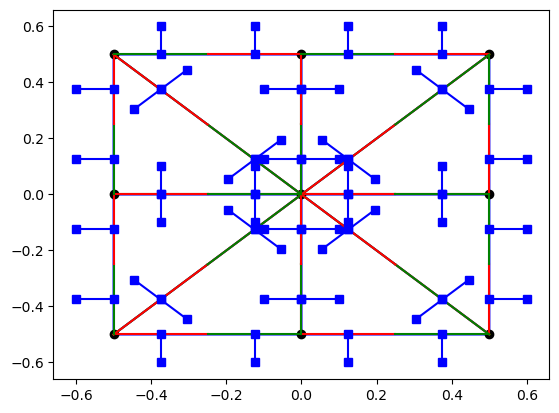

In [7]:
info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)            

fig = plt.figure()
plt.triplot(info.V[:,0],info.V[:,1],info.T,color='b')
for v in range(len(info.V)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    
    for e in range(cv.K):
        start = cv.c
        end = cv.c + cv.Sij[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
                   
        start = cv.c
        end = cv.c + cv.Sik[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-g')

        start = cv.c+cv.Sij[e]/2
        end = cv.c+cv.Sij[e]/2 + cv.Nij[e]*0.1
        plt.plot([start[0], end[0]],[start[1], end[1]],'-bs')
                   
        start = cv.c+cv.Sik[e]/2
        end = cv.c+cv.Sik[e]/2 + cv.Nik[e]*0.1
        plt.plot([start[0], end[0]],[start[1], end[1]],'-bs')
plt.show()    

Next will will render the control volume shapes so we can see how they look like. They have a very specific shape and it is easy to verify by visual inspection if they have been created correctly.

c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


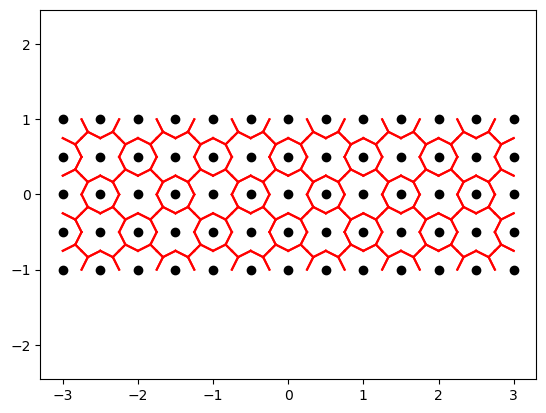

In [8]:
V, T = make_beam_mesh(6.0,2.0,(12,4))

info = MeshInfo(V,T)

CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)

fig = plt.figure()
ax = plt.subplot(111)
for v in range(len(CVs)):
    cv = CVs[v]
    plt.plot(cv.c[0],cv.c[1],'ko')
    for e in range(cv.K):
        start = cv.c + cv.Sij[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
        start = cv.c + cv.Sik[e]
        end = cv.P[e]
        plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
ax.axis('equal')
plt.show()

# Creating a 2D Hyperelastic Simualtor

This is your task to implement this...

In [9]:
def plot_cvs(CVs):
    #plt.figure()
    #ax = plt.subplot(111)
    for v in range(len(CVs)):
        cv = CVs[v]
        plt.plot(cv.c[0],cv.c[1],'ko')
        for e in range(cv.K):
            start = cv.c + cv.Sij[e]
            end = cv.P[e]
            plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
            start = cv.c + cv.Sik[e]
            end = cv.P[e]
            plt.plot([start[0], end[0]],[start[1], end[1]],'-r')
    plt.axis('equal')
    #plt.show()

In [10]:
def calc_kin(v):
    res = np.dot(v,v)
    return res

def calc_psy(lam,mu,E):
    res = (lam/2)*(np.trace(E)**2) + mu*np.trace(E**2)
    return res

In [11]:
Ey = 10e5
nu = 0.3

lambda_ =  (Ey*nu) /((1+nu)*(1-2*nu))   #26.5 #GPa
mu_ = (Ey/(2*(1+nu)))#54.9 #GPa 
print(lambda_,mu_)

576923.0769230769 384615.3846153846


c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
c:\Users\pc\anaconda3\envs\cmis\lib\site-packages\ipykernel_launcher.py:38: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional

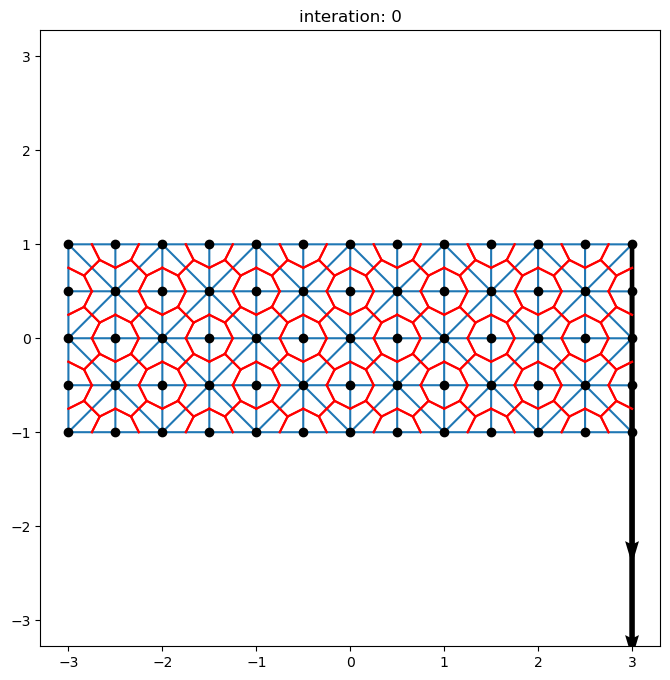

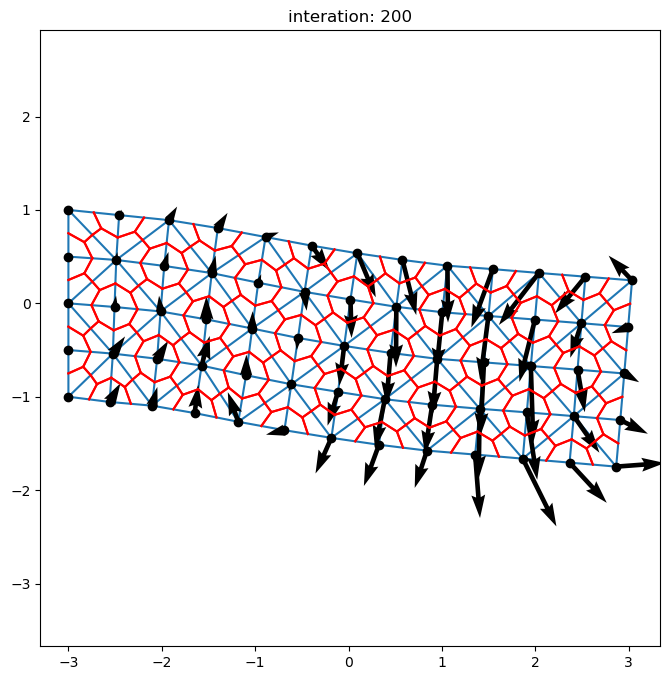

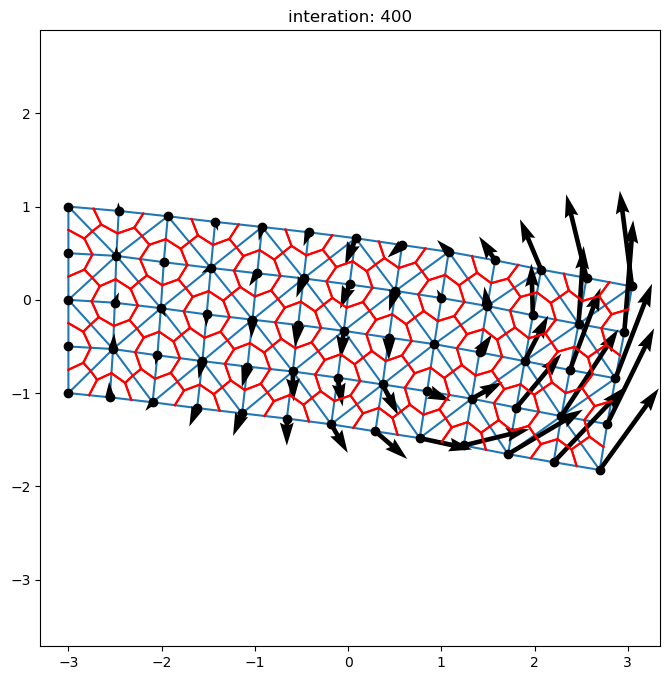

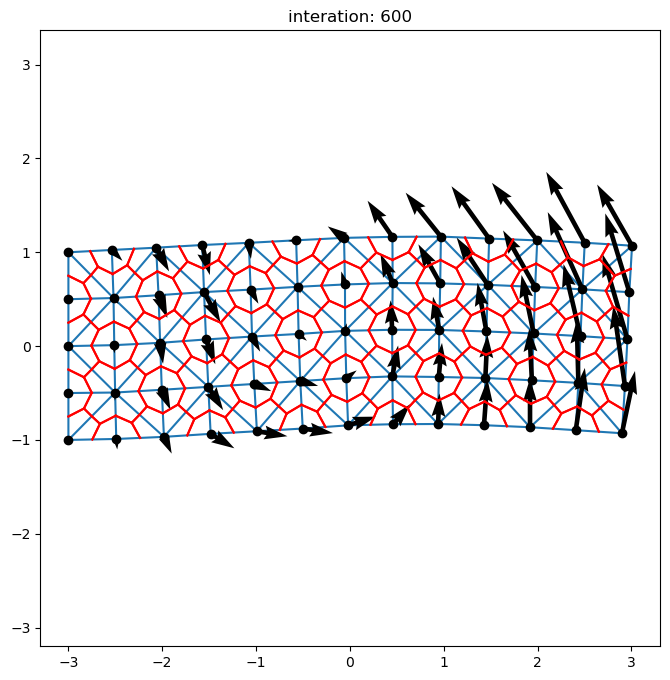

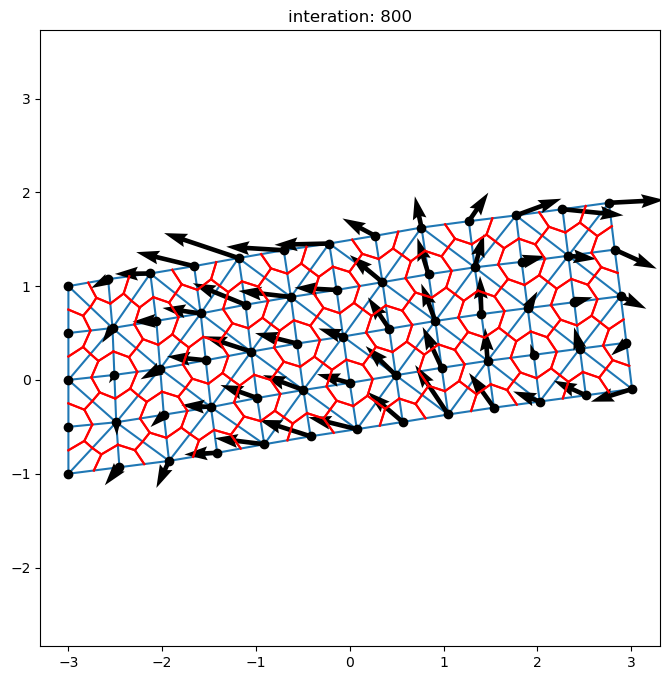

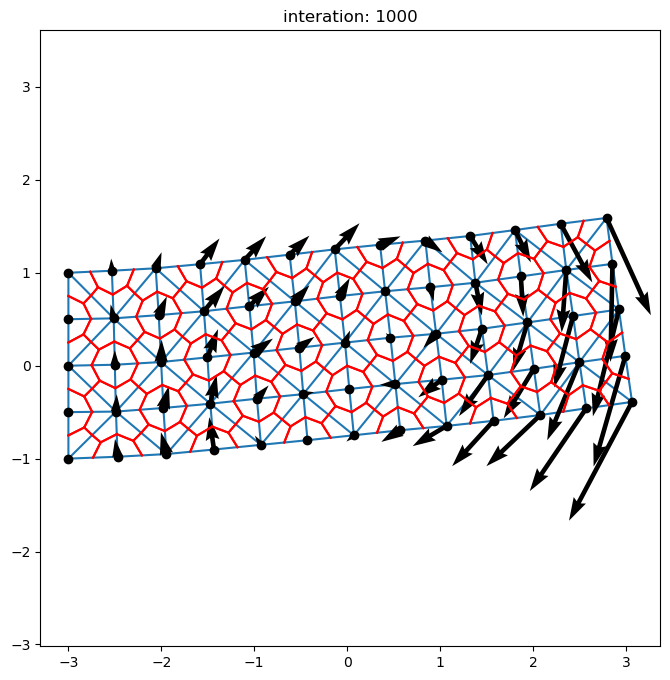

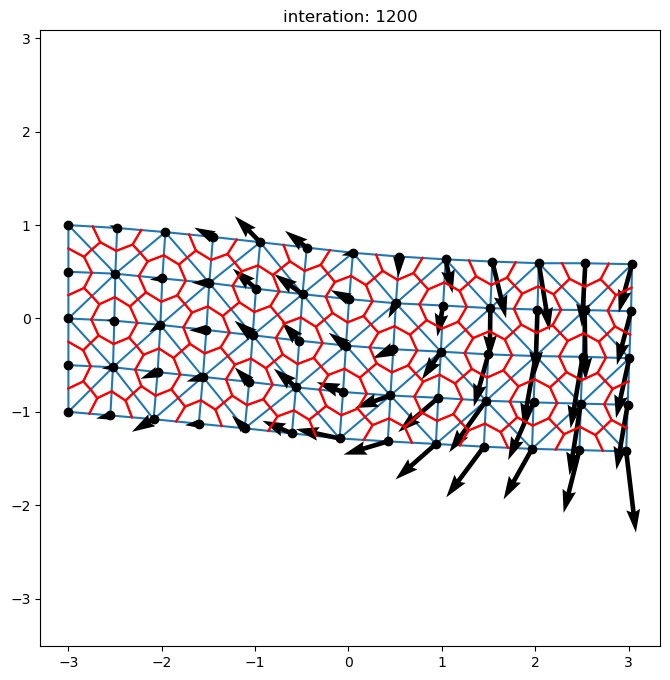

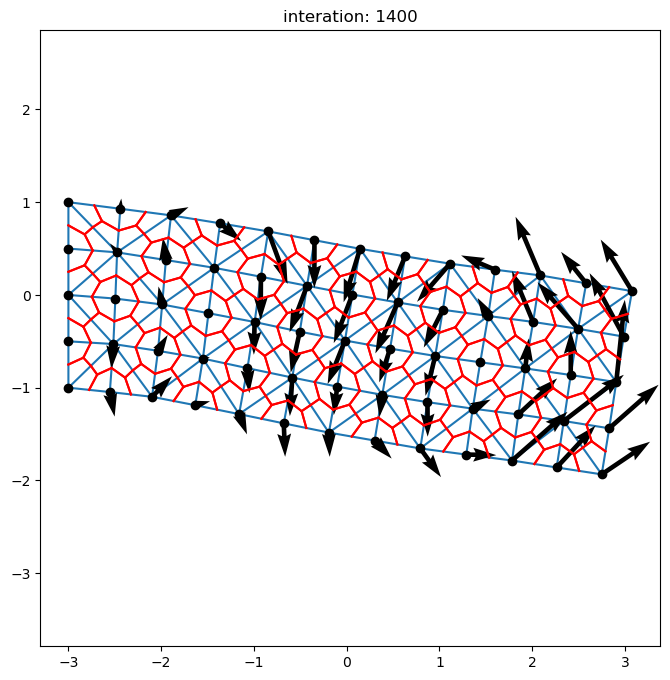

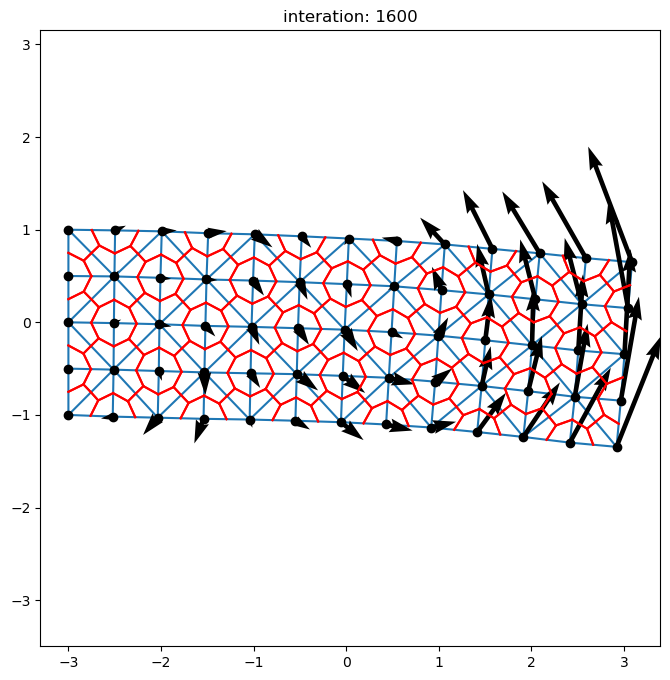

In [12]:
#MATERIAL AND LOAD
rho = 100 #0.01#0.01
b = np.array([0,0])

Ey = 10e5
nu = 0.3

lambda_ =  (Ey*nu) /((1+nu)*(1-2*nu))       # old :26.5 #GPa
mu_ = (Ey/(2*(1+nu)))                       # old :54.9 #GPa 



load_traction = np.array([0,-20000],dtype=np.float64)
max_iter = 2

E_kins = []
E_pots = []
E_elas = [] 

#TIME
CUR_t = 0
max_t = 10
dt = 0.001


#CONTROL VOLUME
V, T = make_beam_mesh(6.0,2.0,(12,4))

info = MeshInfo(V,T)
CVs = []
for v in range(len(V)):
    cv = VertexControlVolume(v,info)
    CVs.append(cv)

amt = 8 #ammount_of_triangles
#left boundary
#LB = np.array([])
LB = np.array(np.where(V[:,0]<-2.8),dtype=np.int).flatten() 
#right boundary
#RB = np.array([])
RB = np.array(np.where(V[:,0]>2.8),dtype=np.int).flatten() 


#At time t=0
D0_inv = np.zeros((len(CVs),amt,2,2))   #8 is the maximum number of triangles in 1 CV
A0 = np.zeros((len(CVs)))               #Area of CVs t=0
Nik0 = np.zeros((len(CVs),amt,2))       #8 is the maximum number of triangles in 1 CV
Nij0 = np.zeros((len(CVs),amt,2))       #8 is the maximum number of triangles in 1 CV
Lij0 = np.zeros((len(CVs),amt))         #8 is the maximum number of triangles in 1 CV
Lik0 = np.zeros((len(CVs),amt))         #8 is the maximum number of triangles in 1 CV

Sij0 = np.zeros((len(CVs),amt,2))
Sik0 = np.zeros((len(CVs),amt,2))

V0 = np.copy(V)


for i in range(len(CVs)):      
        cv = CVs[i]
        A0[i] = cv.A

        for e in range(cv.K):

            Lij = cv.Lij[e]   #half length ij
            Lik = cv.Lik[e]   #half length ik
            Sij = cv.Sij[e,:] #half sengment ij
            Sik = cv.Sik[e,:] #half sengment ik
            Nij = cv.Nij[e,:] #outward-facing normal unit vector for egde ij
            Nik = cv.Nik[e,:] #outward-facing normal unit vector for egde ik

            Nik0[i,e,:] = Nik 
            Nij0[i,e,:] = Nij
            Lij0[i,e] = Lij
            Lik0[i,e] = Lik

            Sik0[i,e,:] = Sik 
            Sij0[i,e,:] = Sij
            D0_inv[i,e,:] = np.linalg.inv(np.array([Sij, Sik]).T)


#stratching test
#V[:,0] = V[:,0]*0.8
#[:,1] = V[:,1]*2


ctr = -1

vels = np.zeros(V.shape)
while CUR_t < max_t:
    ctr += 1

    E_kins_iter = 0
    E_elas_iter = 0
    for v in range(len(CVs)):
        cv = CVs[v]
        
        if v in LB: #dirchlet
            continue
        
        ft = np.array([0,0],dtype=np.float64)
        #if v in RB: #traction
            #print("node:")
        #    ft = load_traction #should be scaled with edge length


        T_2 = info.T[cv.labels,:]
        for t in range(len(T_2)):
            T_2[t,:] = get_cyclic_permuation(v, T_2[t,:]) 
        

        fie = np.zeros((1, 2))
        edge_ctr = 0
        e_elas = 0
        #cv_mass = 0
        for e in range(cv.K):
            edge_ctr += 1
            #calculate DE
            i = T_2[e,0]
            j = T_2[e,1]
            k = T_2[e,2]
            
            pi = V[i,:]
            pj = V[j,:]
            pk = V[k,:]
            
            Sij = (pj-pi)/2
            Sik = (pk-pi)/2

            if v in RB:
                #print(np.linalg.norm(Sij),np.linalg.norm(Sik),"pi:", pi, "pj:", pj, "pk:",pk)
                if ctr <= 50:
                    if edge_ctr == 1 and V0[k,:][0] > 2.9:
                        #print("iter1 pk",pk)
                        ft += Lik0[v,e] * load_traction
                    if edge_ctr == cv.K and V0[j,:][0] > 2.9:
                        #print("last iter pj", pj)
                        ft += Lij0[v,e] * load_traction

            


            #calculate F, E, S, P 
            F = np.array([Sij, Sik]).T @ D0_inv[v,e,:] #transpose twice to get [[x,x],[y,y]]
            #print("F",F)
            E = 0.5 * (F.T@F-np.identity(2))
            S = lambda_ * np.trace(E)*np.identity(2) + 2*mu_ *E
            P = F@S
            
            #calculate fie
            fie += (-P@Nij0[v,e,:]*Lij0[v,e] -P@Nik0[v,e,:]*Lik0[v,e])

            #calculate elastic
            xi = V[i,0]
            xj = V[j,0]
            xk = V[k,0]
            yi = V[i,1]
            yj = V[j,1]
            yk = V[k,1]
            dx1 = xk - xj
            dy1 = yk - yj
            dx2 = xi - xj
            dy2 = yi - yj

            A_temp =  (dx1*dy2 - dx2*dy1 ) / 2.0
            e_elas += (A_temp/3) * calc_psy(lambda_, mu_,E)

            #cv mass
            #cv_mass += cv.A * rho

        E_elas_iter += e_elas



        

        #calculate velocity
        #print(vels.shape, fie.shape)
        fb = A0[i]*b
        #if v in RB:
        #    print("FFFFTTTTT",ft)
        ftotal = fie + ft + fb#add more forces later
        vels[v,:] = vels[v,:] + (dt/(A0[v]*rho)) * ftotal

        #compute kinetic energy
        E_kins_iter += (1/2) *(cv.A)* rho * calc_kin(vels[v,:]) # (vels[v,:].T @ vels[v,:])#calc_kin(vels[v,:])#cv_mass* calc_kin(vels[v,:])
        #print(ctr, calc_kin(vels[v,:]))
        

    #update positions
    for j in range(len(CVs)):
        V[j,:] += dt * vels[j,:]
  
    CUR_t += dt
    E_elas.append(E_elas_iter)
    E_kins.append(E_kins_iter)


    if (ctr % 200) == 0:
        plt.figure(figsize=(8,8))
        #plt.subplot(1,2,1)
        plt.triplot(V[:,0],V[:,1],T)
        #plt.quiver(V[:,0],V[:,1],vel[:,0],vel[:,1])
        #print("velocities",vel)
        #print("ctr",ctr,vel)
        #plt.subplot(1,2,2)
        info2 = MeshInfo(V,T)
        CVs2 = []
        for v2 in range(len(V)):
            cv2 = VertexControlVolume(v2,info2)
            CVs2.append(cv2)
        plot_cvs(CVs2)


        plt.quiver(V[:,0],V[:,1],vels[:,0],vels[:,1])
        #plt.xlim((-6,6))
        plt.title("interation: " + str(ctr))
        plt.show()

    if ctr == 1600:#max_iter:
        break





In [13]:
print(E_kins)

[18.000000000000004, 67.52313376749053, 138.36839246435142, 221.20816395425794, 311.47966462329856, 407.7008887799527, 507.2230642804282, 604.8092330849063, 695.9487629342367, 781.3640579340521, 867.6365393159265, 962.815968505992, 1070.9653798159784, 1190.5165204317118, 1317.3643573779807, 1449.131352530479, 1586.505109365848, 1731.0703661316081, 1882.5889593539607, 2038.7076044303253, 2197.1521276579138, 2357.9913158904073, 2523.7830535249127, 2697.593249659196, 2880.7093509813685, 3071.855881048416, 3268.209703125998, 3467.0804695747206, 3666.944461397855, 3867.3660508495745, 4068.207186605317, 4268.873346710149, 4468.269617330185, 4665.697758251437, 4862.11175949476, 5060.529077905696, 5264.826759761784, 5477.572756745795, 5698.633455841938, 5925.788232653176, 6156.74347929969, 6390.551100709306, 6627.057657388731, 6865.175912965134, 7102.189136443196, 7335.275365824852, 7563.966690393796, 7791.06081122492, 8020.938209276634, 8256.784154512723, 8499.20441513609, 8379.58985879041, 8

In [14]:
print(E_elas)

[0.0, 0.4846210172306996, 3.5032985973448336, 9.962958840796887, 17.097571198221672, 20.001857899468874, 16.268552648651706, 9.140447943892962, 5.683509112131956, 11.361670665713065, 26.027462398922186, 44.97042198294778, 63.766362078288054, 82.23028414295378, 104.03712727914008, 132.93733542699482, 169.47406330772074, 211.02630979027543, 254.45972945550844, 298.4463824344638, 343.479664801624, 390.16958533398486, 437.8331191082156, 484.70808785957604, 529.3921478264404, 572.0085436687048, 614.0089489364692, 656.9050104914913, 701.1672806967321, 746.2324216108705, 791.5253497053241, 837.6217749826509, 886.5788256451025, 940.9648147765096, 1002.0525755747108, 1068.5139785472984, 1136.8774777336557, 1203.679544216661, 1267.7012204928449, 1330.4640495088345, 1394.6499120832093, 1461.9932494283687, 1532.6128513604463, 1606.174222687286, 1683.268719140527, 1765.1617859189237, 1851.9529961617054, 1941.124819807406, 2028.2532523195364, 2109.514212576881, 2183.8077573891896, 2252.684143792105,

In [15]:
print(np.array(E_kins)+ np.array(E_elas))

[   18.            68.00775478   141.87169106 ... 11286.44567206
 11317.72271094 11347.05102744]


In [16]:
print(T.shape)
print(V.shape)

(96, 3)
(65, 2)


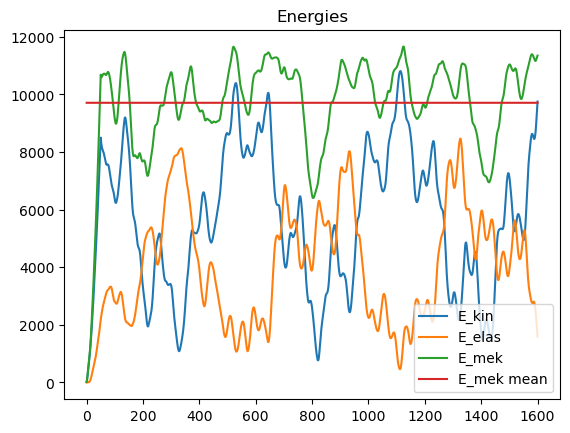

In [17]:
plt.plot(E_kins,label="E_kin")
plt.plot(E_elas,label = "E_elas")
plt.plot(np.array(E_kins)+np.array(E_elas),label ="E_mek")
mean = np.mean(np.array(E_kins)+np.array(E_elas))
means = [mean for x in range(len(E_kins))]
plt.plot(means,label = "E_mek mean")

plt.title("Energies")
plt.legend()
plt.show()
